##### Executed Notebook implementing CNN with PyTorch - final Test Accuracy 94.78 %

# Global variables - this cell defines the variables used through the notebook

In [30]:
import os
import numpy as np

# VARIABLE DEFINITIONS

# location of the datasets
# The data should be organized as the following structure
data_dir = './GTSRB'
train_path = './GTSRB/Training'
test_path = './GTSRB/Final_Test'

# Resizing the images to 30x30x3 - standard for image classification
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

# number of categories defined in the data
# how many classes in the data
NUM_CATEGORIES = len(os.listdir(train_path))

# Label Overview
# These are the classes defined in the dataset
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# This cell visualizes the data

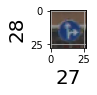

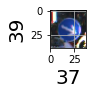

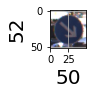

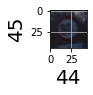

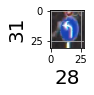

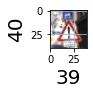

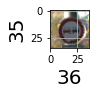

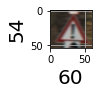

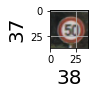

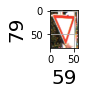

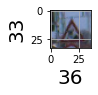

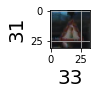

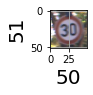

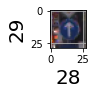

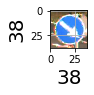

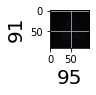

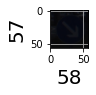

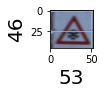

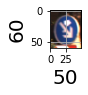

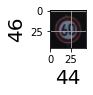

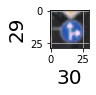

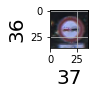

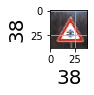

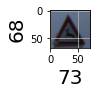

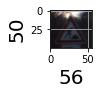

In [31]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from GLOBAL_VARS import *

folders = os.listdir(train_path)

train_number = []
class_num = []

all_files = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    for file in train_files:
        all_files.append(train_path + '/' + folder + '/' + file)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# print(all_files)
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]




# Visualizing 25 random images from test data
import random
from matplotlib.image import imread


# plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path =  random.choice(all_files)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image
    plt.show()


# Create train and validation data splits

In [32]:
import pickle as pkl
import random 
import torch
import numpy as np
import math
from PIL import Image

from torch.utils.data import Dataset

def filter_csv(train_files, class_labels):
    ret_files = []
    ret_labels = []

    for i, file in enumerate(train_files):
        if not '.csv' in file:
            ret_files.append(file)
            ret_labels.append(class_labels[i])

    return ret_files, ret_labels

def index_list(input_list, indices):
    new_list = [input_list[i] for i in indices]

    return new_list

if __name__ == "__main__":
    folders = os.listdir(train_path)

    train_number = []
    class_num = []

    all_files = []
    all_class_labels =[]

    
    # load all files
    for folder in folders:
        train_files = os.listdir(train_path + '/' + folder)
        for file in train_files:
            all_files.append(train_path + '/' + folder + '/' + file)
            all_class_labels.append(int(folder))

    files_no_csv, filter_labels_no_csv = filter_csv(all_files, all_class_labels)
    
    # randomly split files into 70% and 30% for training and validation
    seventy_percent = 0.7 * len(files_no_csv)

    mylist = []
    nums = 0
    while(True):
        x = random.randint(0, len(files_no_csv)-1)
        if not(x in mylist):
            mylist.append(x)
            nums += 1
        
        if nums == seventy_percent:
            break

    invert_list = list(set(list(range(0, len(files_no_csv)))).difference(set(mylist)))
    
    # save the split file
    save_dict = {
        'train_files': index_list(files_no_csv, mylist),
        'train_labels': index_list(filter_labels_no_csv, mylist),

        'val_files': index_list(files_no_csv, invert_list),
        'val_labels': index_list(filter_labels_no_csv, invert_list)
    }

    save_file = "./train_val_split.pkl"

    with open(save_file, 'wb') as f:
        pkl.dump(save_dict, f)

# Dataloader for training and validation 
#### Loads data in batches for network training

In [33]:
import pickle as pkl
import torch
import numpy as np
import math
from PIL import Image

from torch.utils.data import Dataset
from torchvision import transforms, datasets


def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

class ImageDataset(Dataset):
    def __init__(self, type_val_train ):
        """
        Args:
        """
        # transform definition
        self.transforms =  transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

        # open split file
        save_file = "./train_val_split.pkl"


        with open(save_file, 'rb') as f:
            data = pkl.load(f)
        
        if type_val_train == "train":
            self.files = data['train_files']
            self.labels = data['train_labels']

        else:
            self.files = data['val_files']
            self.labels = data['val_labels']

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
            Get the data corresponding to the idx
        """
        file = self.files[idx]
        label = self.labels[idx]

        image = np.asarray(Image.open(file))
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = np.asarray(image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH)))

        image = self.transforms(resize_image)
        ret_dict = {
            'image': image,
            'label': torch.tensor(label, dtype = torch.long)
        }
        return ret_dict


if __name__ == "__main__":
    dataset_new = ImageDataset('val')
    dataset_new[0]

# Dataloader for testing

In [34]:
import pickle as pkl
import torch
import numpy as np
import math
# import cv2 
from PIL import Image

from torch.utils.data import Dataset
from torchvision import transforms, datasets


def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

class TestImageDataset(Dataset):
    def __init__(self):
        """
        Args:
        """
        test_path  = './GTSRB/Final_Test'
        labels = './GTSRB/Test.csv'
        import csv

        rows = []

        with open(labels, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter = ';')
            for row in spamreader:
                rows.append(row)
                
        # print(rows)
        folders = os.listdir(test_path)

        all_files = []
        all_class_labels =[]

        for i, row in enumerate(rows):
            if i == 0:
                continue

            filename = './GTSRB/Final_Test/Images/{}'.format(row[0])
            all_files.append(filename)
            class_label = row[-1]
            all_class_labels.append(class_label)

        self.transforms =  transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
        self.files = all_files
        self.labels = all_class_labels
        ## open csv file
        # find the true class 

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
            Get the data corresponding to the idx
        """
        file = self.files[idx]
        label = self.labels[idx]

        image = np.asarray(Image.open(file))
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = np.asarray(image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH)))

        image = self.transforms(resize_image)

        ret_dict = {
            'image': image,
            'label': torch.tensor(int(label), dtype = torch.long)
        }

        return ret_dict

# Network definition

In [35]:
import torch
from torch import nn
from torch import optim

# network definition
class Classifier(nn.Module):
    def __init__(self, input_dim=512, output_dim=43):
        super(Classifier, self).__init__()
        
        # convolution layers
        self.conv2d_a = nn.Conv2d(3, 16, kernel_size=(3,3))
        self.conv2d_b  = nn.Conv2d(16, 32, kernel_size=(3,3))
        
        # maxpool layers
        self.maxpool1 = nn.MaxPool2d((2, 2))
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        # convolution layers
        self.conv2d_c = nn.Conv2d(32, 32, kernel_size=(3,3))
        self.conv2d_d  = nn.Conv2d(32, 32, kernel_size=(3,3))
        self.maxpool2 = nn.MaxPool2d((2, 2))
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.layer_1 = nn.Linear(input_dim, output_dim)
       
    def forward(self, x):
        # forward pass through the network 
        bs, c, h, w= x.shape
        
        # forward pass through one set of convolutions, maxpool and batchnorm layers
        x = self.batchnorm1(self.maxpool1(self.conv2d_b(self.conv2d_a(x))))
        
        # forward pass through one set of convolutions, maxpool and batchnorm layers
        x = self.batchnorm2(self.maxpool2(self.conv2d_d(self.conv2d_c(x))))
        
        new_x = torch.reshape(x, (bs, -1))

        # pass through the linear layer of the network
        x = torch.nn.functional.relu(self.layer_1(new_x))
        x = torch.nn.functional.sigmoid(x)
        return x

# Main execution - iterate over the dataset and train the main network

In [36]:
import numpy as np
# import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from PIL import Image

from torch.utils.data import DataLoader


# create datasets
train_set = ImageDataset('train')
val_set = ImageDataset('val')
test_set = TestImageDataset()

lr = 0.0001
epochs = 30

# create network
network = Classifier()

# using adam optimizer
opt = torch.optim.Adam(lr=lr, params = network.parameters())

# define loss
loss = torch.nn.CrossEntropyLoss()

# this defines the dataloader for training
dataloader_train = DataLoader(train_set, batch_size = 32, num_workers = 32)

# this defines the dataloader for testing
dataloader_test = DataLoader(test_set, batch_size = 32, num_workers = 32)

# this defines the dataloader for validation
dataloader_val =  iter(DataLoader(val_set, batch_size = 32, num_workers = 32))

# iterate over the epochs
for epoch in range(epochs):
    
    # iterate over training dataloader
    for i, dict in enumerate(dataloader_train):
        
        # get the image
        img = dict['image']
        
        # get the gt label
        gt = dict['label']
        
        # define the optimizer
        opt.zero_grad()
        
        # pipe the image through the network
        output = network(img)
        
        # compute loss
        loss_val = loss(output, gt)
        
        # run backprop
        loss_val.backward()
        
        # take an optimization step
        opt.step()
        
        # every 100 iterations, evaluate the model on the validation set
        if i%100 == 0:
            val_dict = next(dataloader_val)
            val_img = val_dict['image']
            val_gt = val_dict['label']

            with torch.no_grad():
                output = network(val_img)

            validation_loss = loss(output, val_gt)
            acc = (torch.argmax(output, 1) == val_gt).float().mean()

            print("Epoch {} Iteration {}".format(epoch, i))
            print("Validation loss", validation_loss.item())
            print("Validation Accuracy {} %".format(acc.item() * 100))

    # check the method on test dataset every two epochs
    if epoch % 2 == 0:
        all_accs = []
        for i, dict in enumerate(dataloader_test):
            img = dict['image']
            gt = dict['label']

            with torch.no_grad():
                output = network(img)
            acc = (torch.argmax(output, 1) == gt).float().mean()
            all_accs.append(acc.cpu().numpy())

        print('========================\n TEST ACCURACY {} %\n ========================'.format((np.mean(all_accs)*100)))




Epoch 0 Iteration 0
Validation loss 3.8054747581481934
Validation Accuracy 0.0 %
Epoch 0 Iteration 100
Validation loss 3.669649362564087
Validation Accuracy 9.375 %
Epoch 0 Iteration 200
Validation loss 3.584925651550293
Validation Accuracy 25.0 %
Epoch 0 Iteration 300
Validation loss 3.5327749252319336
Validation Accuracy 46.875 %
Epoch 0 Iteration 400
Validation loss 3.529599905014038
Validation Accuracy 31.25 %
Epoch 0 Iteration 500
Validation loss 3.5233867168426514
Validation Accuracy 40.625 %
 TEST ACCURACY 52.322351932525635 %
Epoch 1 Iteration 0
Validation loss 3.463921308517456
Validation Accuracy 56.25 %
Epoch 1 Iteration 100
Validation loss 3.4112868309020996
Validation Accuracy 62.5 %
Epoch 1 Iteration 200
Validation loss 3.3675100803375244
Validation Accuracy 87.5 %
Epoch 1 Iteration 300
Validation loss 3.36415433883667
Validation Accuracy 81.25 %
Epoch 1 Iteration 400
Validation loss 3.3591439723968506
Validation Accuracy 87.5 %
Epoch 1 Iteration 500
Validation loss 3.380

 TEST ACCURACY 91.38162136077881 %
Epoch 15 Iteration 0
Validation loss 3.318608283996582
Validation Accuracy 93.75 %
Epoch 15 Iteration 100
Validation loss 3.327033519744873
Validation Accuracy 90.625 %
Epoch 15 Iteration 200
Validation loss 3.3346004486083984
Validation Accuracy 93.75 %
Epoch 15 Iteration 300
Validation loss 3.3204267024993896
Validation Accuracy 93.75 %
Epoch 15 Iteration 400
Validation loss 3.3333890438079834
Validation Accuracy 96.875 %
Epoch 15 Iteration 500
Validation loss 3.3398537635803223
Validation Accuracy 81.25 %
Epoch 16 Iteration 0
Validation loss 3.309408664703369
Validation Accuracy 93.75 %
Epoch 16 Iteration 100
Validation loss 3.3065404891967773
Validation Accuracy 100.0 %
Epoch 16 Iteration 200
Validation loss 3.355959177017212
Validation Accuracy 90.625 %
Epoch 16 Iteration 300
Validation loss 3.3502557277679443
Validation Accuracy 90.625 %
Epoch 16 Iteration 400
Validation loss 3.344424247741699
Validation Accuracy 90.625 %
Epoch 16 Iteration 500


Epoch 29 Iteration 400
Validation loss 3.2959611415863037
Validation Accuracy 100.0 %
Epoch 29 Iteration 500
Validation loss 3.313260793685913
Validation Accuracy 93.75 %
